# Imports

In [3]:
import pandas as pd
import numpy as np
from scipy                 import stats  as ss


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display       import Image
from sklearn.model_selection import KFold, cross_validate

# Funções

In [4]:
def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is None:
        labels = np.unique(y_true)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def rescale_column(data, column_name):
    """
    Função para reescalar uma coluna específica do DataFrame para o intervalo [0, 1].

    Parâmetros:
        - data: DataFrame contendo os dados.
        - column_name: Nome da coluna a ser reescalada.

    Retorna:
        - DataFrame: dados com a coluna reescalada.
    """
    min_val = data[column_name].min()
    max_val = data[column_name].max()
    data[column_name] = (data[column_name] - min_val) / (max_val - min_val)
    return data


# Data Load

In [5]:
df = pd.read_csv('credit_risk_dataset.csv')

In [6]:
df.rename(columns={
    'person_age': 'idade',
    'person_income': 'renda',
    'person_home_ownership': 'posse_casa',
    'person_emp_length': 'tempo_emprego',
    'loan_intent': 'finalidade_emprestimo',
    'loan_grade': 'grau_risco_emprestimo',
    'loan_amnt': 'valor_emprestimo',
    'loan_int_rate': 'taxa_juros_emprestimo',
    'loan_status': 'status_emprestimo',
    'loan_percent_income': 'relacao_emprestimo_renda',
    'cb_person_default_on_file': 'registro_inadimplencia',
    'cb_person_cred_hist_length': 'historico_credito'
}, inplace=True)

In [7]:
df.head()

,idade,renda,posse_casa,tempo_emprego,finalidade_emprestimo,grau_risco_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,registro_inadimplencia,historico_credito
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# 1.0 Data Description

In [8]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [9]:
df1.shape

(32581, 12)

## 1.2 Tipo dos Dados

In [10]:
df1.dtypes

idade                         int64
renda                         int64
posse_casa                   object
tempo_emprego               float64
finalidade_emprestimo        object
grau_risco_emprestimo        object
valor_emprestimo              int64
taxa_juros_emprestimo       float64
status_emprestimo             int64
relacao_emprestimo_renda    float64
registro_inadimplencia       object
historico_credito             int64
dtype: object

## 1.3 Check Na

In [11]:
df1.isna().sum()

idade                          0
renda                          0
posse_casa                     0
tempo_emprego                895
finalidade_emprestimo          0
grau_risco_emprestimo          0
valor_emprestimo               0
taxa_juros_emprestimo       3116
status_emprestimo              0
relacao_emprestimo_renda       0
registro_inadimplencia         0
historico_credito              0
dtype: int64

## 1.4 Fill Na

In [12]:
df1 = df1.dropna()

In [13]:
df1.head()

,idade,renda,posse_casa,tempo_emprego,finalidade_emprestimo,grau_risco_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,registro_inadimplencia,historico_credito
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## 1.5 Estatística Descritiva

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

### 1.5.1 Variáveis Numéricas

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,idade,20.00,144.00,124.00,27.727216,26.00,6.310331,2.564863,18.718747
1,renda,4000.00,6000000.00,5996000.00,66649.371884,55956.00,62355.358694,35.190623,2956.064707
2,tempo_emprego,0.00,123.00,123.00,4.788672,4.00,4.154554,2.752939,47.639702
3,valor_emprestimo,500.00,35000.00,34500.00,9656.493121,8000.00,6329.572848,1.174480,1.350012
4,taxa_juros_emprestimo,5.42,23.22,17.80,11.039867,10.99,3.229315,0.203978,-0.661337
5,status_emprestimo,0.00,1.00,1.00,0.216600,0.00,0.411928,1.376039,-0.106523
6,relacao_emprestimo_renda,0.00,0.83,0.83,0.169488,0.15,0.106391,1.077710,1.291548
7,historico_credito,2.00,30.00,28.00,5.793736,4.00,4.038412,1.663378,3.730311


### 1.5.2 Variáveis Categóricas

In [16]:
cat_attributes.describe().T

,count,unique,top,freq
posse_casa,28638,4,RENT,14551
finalidade_emprestimo,28638,6,EDUCATION,5704
grau_risco_emprestimo,28638,7,A,9402
registro_inadimplencia,28638,2,N,23535


# 2.0 Feature Engineering

In [17]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

In [18]:
df2.head()

,idade,renda,posse_casa,tempo_emprego,finalidade_emprestimo,grau_risco_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,registro_inadimplencia,historico_credito
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## 2.2 Criação das Hipóteses

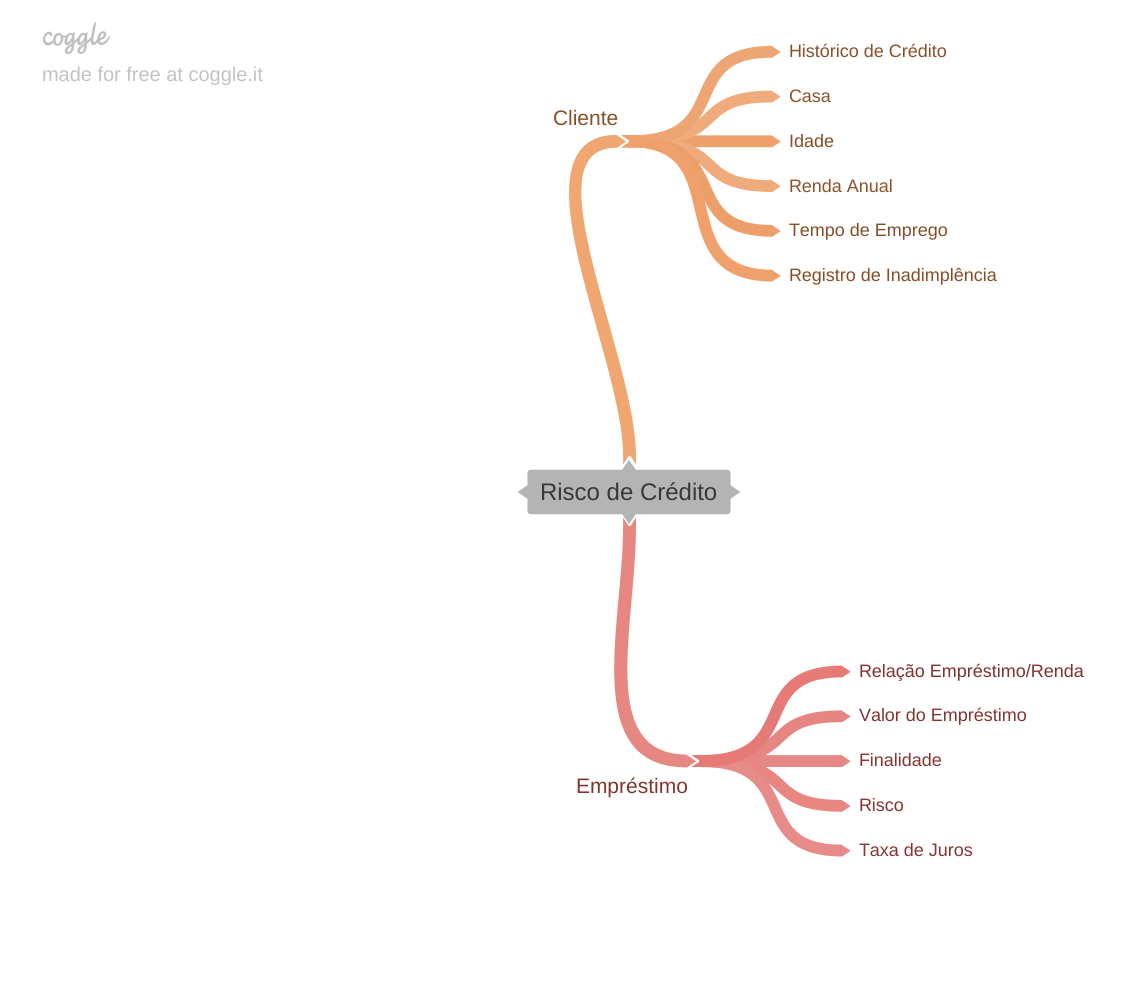

In [19]:
Image( 'mind_map.png' )

### 2.2.1 Hipóteses do Cliente

- Pessoas mais jovens podem ter uma taxa de inadimplência maior devido à falta de experiência financeira e estabilidade profissional.


- Indivíduos com renda mais alta tendem a ter uma menor probabilidade de inadimplência, pois têm mais recursos para cumprir suas obrigações financeiras.


- Pessoas que possuem casa própria podem apresentar uma menor taxa de inadimplência, pois têm um ativo significativo que pode ser usado como garantia.


- Pessoas com um histórico de emprego mais longo podem ter uma menor probabilidade de inadimplência, pois demonstram estabilidade financeira e capacidade de pagamento ao longo do tempo.

- Pessoas com registros anteriores de inadimplência podem ter uma maior probabilidade de inadimplência no futuro, indicando uma tendência de comportamento de risco.

### 2.2.2 Hipóteses do Empréstimo

- A finalidade do empréstimo pode afetar a probabilidade de inadimplência.


- Empréstimos classificados em categorias de maior risco podem ter uma probabilidade maior de inadimplência. 


- Empréstimos de valores mais altos podem apresentar uma maior probabilidade de inadimplência, pois representam um compromisso financeiro maior para o mutuário.


- Taxas de juros mais altas podem aumentar a probabilidade de inadimplência, especialmente para mutuários com renda mais baixa ou histórico de crédito comprometido.


- Uma relação alta entre o valor do empréstimo e a renda da pessoa pode indicar uma capacidade limitada de pagamento e, portanto, uma maior probabilidade de inadimplência.

- Uma taxa ajustada de juros pela renda mais alta está associada a uma maior propabilidade de inadimplência

- Uma alta proporção do valor do empréstimo em relação a idade está associada a uma maior probabilidade de inadimplência

- Uma alta proporção do valor do empréstimo em relação ao tempo de emprego está associada a uma alta probabilidade de inadimplência

- Uma alta proporção do valor do empréstimo em relação ao Histórico de Crédito está associada a uma alta probabilidade de inadimplência

- Uma baixa proporção da renda em relação ao valor do empréstimo está associada a uma probabilidade maior de inadimplência

- Pessoas com renda mais alta têm uma menor probabilidade de inadimplência

- Faixas etárias mais jovens podem estar associadas a uma maior probabilidade de inadimplência

## 2.3 Feature Engineering

In [20]:


# Taxa de Juros Ajustada pela Renda
df2['taxa_juros_ajustada_renda'] = df2['taxa_juros_emprestimo'] / df2['renda']

# Proporção do Valor do Empréstimo em Relação à Idade
df2['proporcao_emprestimo_idade'] = df2['valor_emprestimo'] / df2['idade']

# Proporção do Valor do Empréstimo em Relação ao Tempo de Emprego
df2['tempo_emprego'] = np.where(df2['tempo_emprego'] == 0, 1, df2['tempo_emprego'])
df2['proporcao_emprestimo_tempo_emprego'] = df2['valor_emprestimo'] / df2['tempo_emprego']


# Proporção do Valor do Empréstimo em Relação à História de Crédito
df2['proporcao_emprestimo_historico_credito'] = df2['valor_emprestimo'] / df2['historico_credito']

# Proporção da Renda em Relação ao Valor do Empréstimo
df2['proporcao_renda_emprestimo'] = df2['renda'] / df2['valor_emprestimo']

# Categoria de Renda
faixas_renda = [0, 30000, 60000, 90000, float('inf')]
categorias_renda = ['baixa', 'média baixa', 'média alta', 'alta']
df2['categoria_renda'] = pd.cut(df2['renda'], bins=faixas_renda, labels=categorias_renda)

# Categoria de Idade
faixas_idade = [0, 30, 50, float('inf')]
categorias_idade = ['jovem', 'adulto', 'idoso']
df2['categoria_idade'] = pd.cut(df2['idade'], bins=faixas_idade, labels=categorias_idade)


In [21]:
df2.isna().sum()

idade                                     0
renda                                     0
posse_casa                                0
tempo_emprego                             0
finalidade_emprestimo                     0
grau_risco_emprestimo                     0
valor_emprestimo                          0
taxa_juros_emprestimo                     0
status_emprestimo                         0
relacao_emprestimo_renda                  0
registro_inadimplencia                    0
historico_credito                         0
taxa_juros_ajustada_renda                 0
proporcao_emprestimo_idade                0
proporcao_emprestimo_tempo_emprego        0
proporcao_emprestimo_historico_credito    0
proporcao_renda_emprestimo                0
categoria_renda                           0
categoria_idade                           0
dtype: int64

# 3.0 Filtragem de Variáveis

In [22]:
df3 = df2.copy()

## 3.1 Filtragem de Linhas

In [23]:
df3.head()

,idade,renda,posse_casa,tempo_emprego,finalidade_emprestimo,grau_risco_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,registro_inadimplencia,historico_credito,taxa_juros_ajustada_renda,proporcao_emprestimo_idade,proporcao_emprestimo_tempo_emprego,proporcao_emprestimo_historico_credito,proporcao_renda_emprestimo,categoria_renda,categoria_idade
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0.000272,1590.909091,284.552846,11666.666667,1.685714,média baixa,jovem
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0.001160,47.619048,200.000000,500.000000,9.600000,baixa,jovem
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0.001341,220.000000,5500.000000,1833.333333,1.745455,baixa,jovem
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0.000233,1521.739130,8750.000000,17500.000000,1.871429,média alta,jovem
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0.000262,1458.333333,4375.000000,8750.000000,1.554286,média baixa,jovem


## 3.2 Filtragem de Colunas

# 4.0 Análise Exploratória de Dados

In [24]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

<Axes: xlabel='count', ylabel='status_emprestimo'>

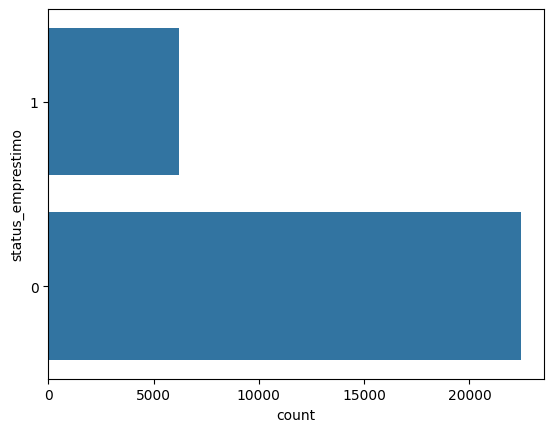

In [25]:
aux = df4.copy()
aux['status_emprestimo'] = aux['status_emprestimo'].astype(str)
sns.countplot(aux['status_emprestimo'])

### 4.1.2 Variáveis Numéricas

In [26]:
num_attributes2 = df4.select_dtypes(exclude=['category', 'object'])

In [27]:
# num_attributes2.hist( bins=25 );

### 4.1.3 Variáveis Categóricas

## 4.2 Análise Bivariada

#### 4.2.1 Hipóteses do Cliente

##### Pessoas mais jovens podem ter uma taxa de inadimplência maior devido à falta de experiência financeira e estabilidade profissional.

<Axes: xlabel='idade', ylabel='Count'>

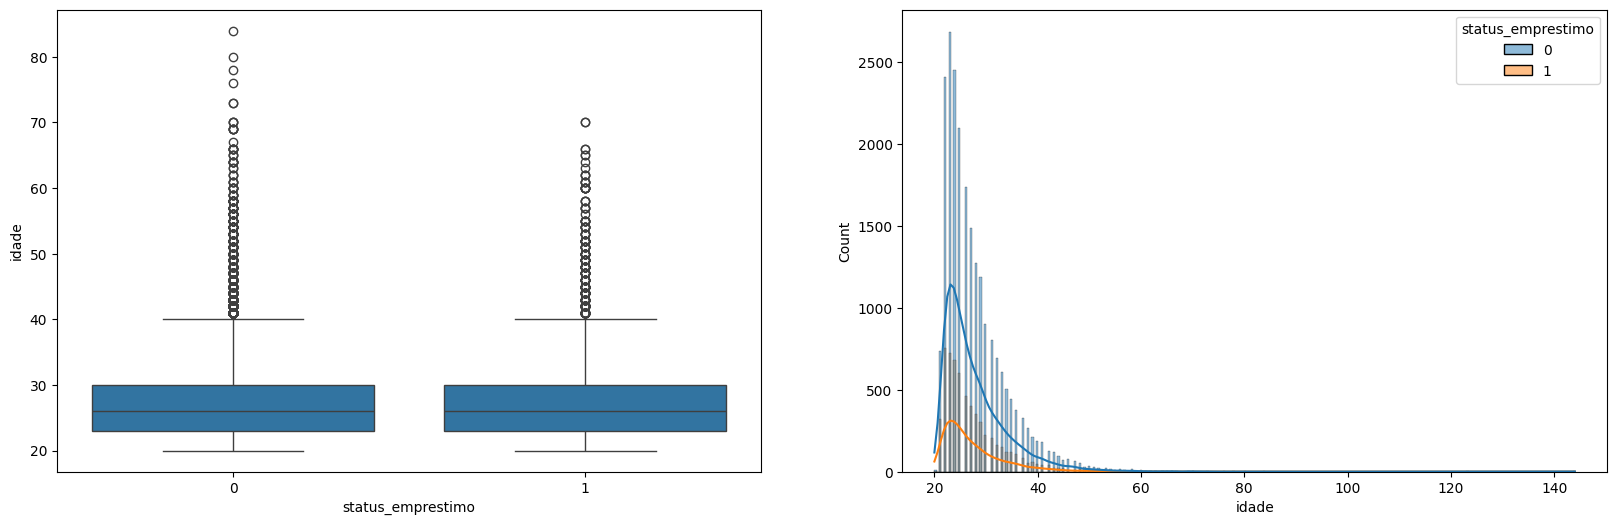

In [28]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='idade', data=df4.loc[df4['idade'] < 100])

plt.subplot(1,2,2)
sns.histplot(data=df4, x='idade', hue='status_emprestimo', kde=True)

##### Indivíduos com renda mais alta tendem a ter uma menor probabilidade de inadimplência, pois têm mais recursos para cumprir suas obrigações financeiras.

C:\Users\thale\AppData\Local\Temp\ipykernel_27484\2621765011.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux = aux[['categoria_renda', 'status_emprestimo']].groupby('categoria_renda').count().reset_index()


<Axes: xlabel='categoria_renda', ylabel='status_emprestimo'>

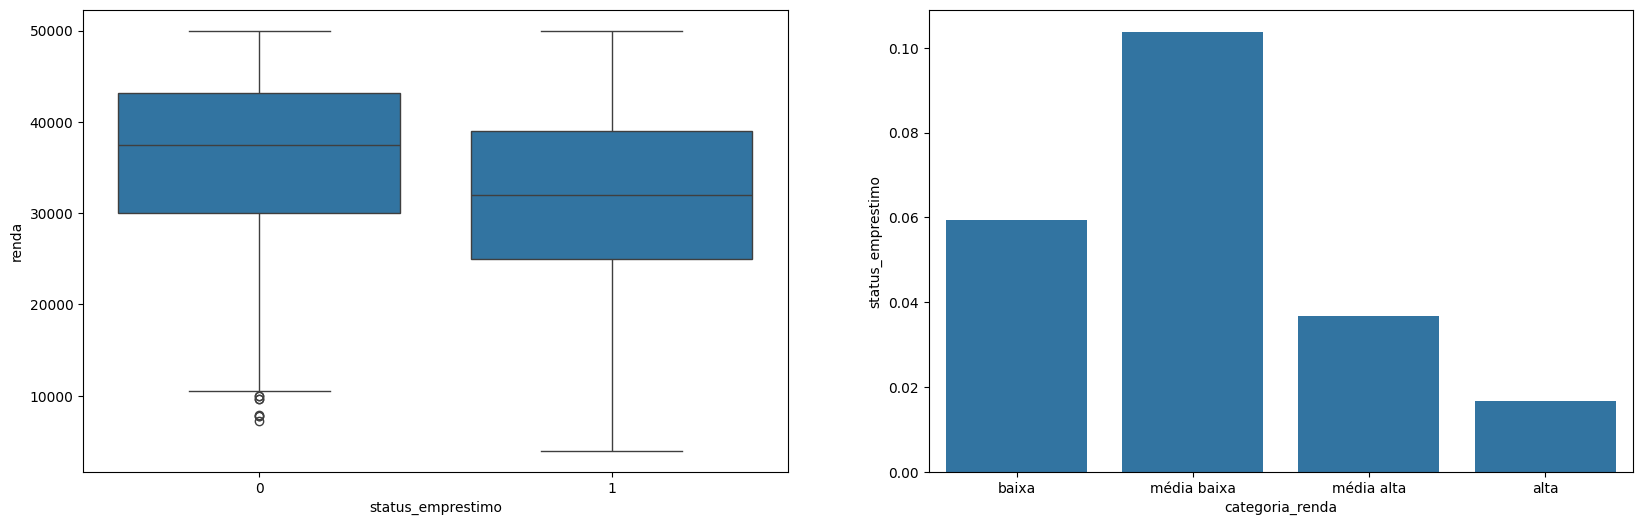

In [29]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='renda', data=df4.loc[df4['renda'] <50000])

plt.subplot(1,2,2)
aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['categoria_renda', 'status_emprestimo']].groupby('categoria_renda').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='categoria_renda', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

##### Pessoas que possuem casa própria podem apresentar uma menor taxa de inadimplência, pois têm um ativo significativo que pode ser usado como garantia.

<Axes: xlabel='posse_casa', ylabel='status_emprestimo'>

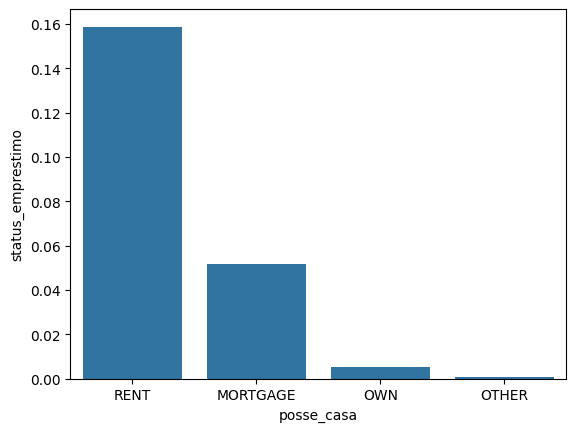

In [30]:
aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['posse_casa', 'status_emprestimo']].groupby('posse_casa').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='posse_casa', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

##### Pessoas com um histórico de emprego mais longo podem ter uma menor probabilidade de inadimplência, pois demonstram estabilidade financeira e capacidade de pagamento ao longo do tempo.


<Axes: xlabel='status_emprestimo', ylabel='tempo_emprego'>

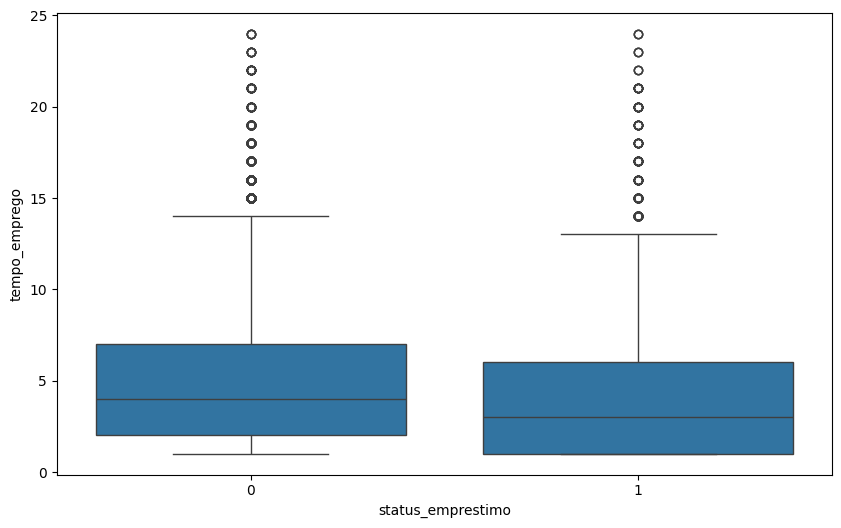

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4.loc[df4['tempo_emprego'] < 25], x='status_emprestimo', y='tempo_emprego')

##### Pessoas com registros anteriores de inadimplência podem ter uma maior probabilidade de inadimplência no futuro, indicando uma tendência de comportamento de risco.

<Axes: xlabel='registro_inadimplencia', ylabel='status_emprestimo'>

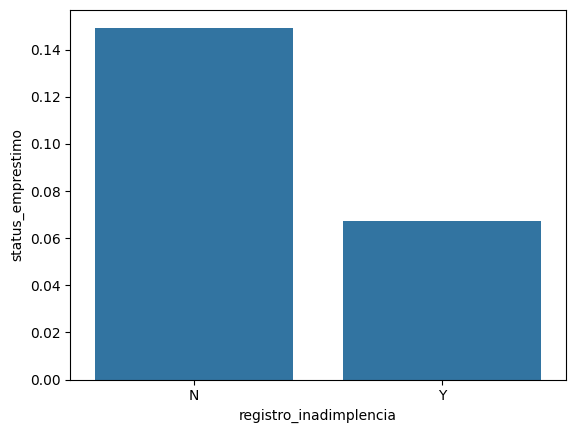

In [32]:
aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['registro_inadimplencia', 'status_emprestimo']].groupby('registro_inadimplencia').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='registro_inadimplencia', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

#### 4.2.2 Hipóteses do Empréstimo

##### A finalidade do empréstimo pode afetar a probabilidade de inadimplência.

<Axes: xlabel='finalidade_emprestimo', ylabel='status_emprestimo'>

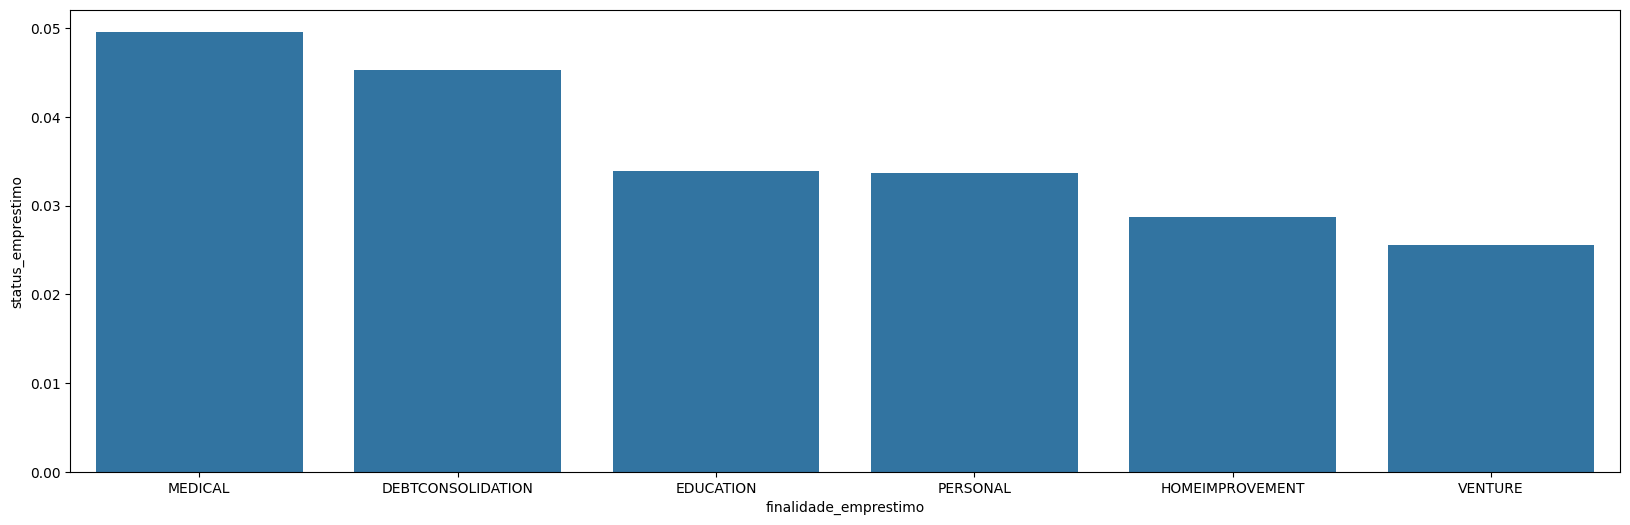

In [33]:
plt.figure(figsize=(20, 6))

aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['finalidade_emprestimo', 'status_emprestimo']].groupby('finalidade_emprestimo').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='finalidade_emprestimo', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

##### Empréstimos classificados em categorias de maior risco podem ter uma probabilidade maior de inadimplência. 

<Axes: xlabel='grau_risco_emprestimo', ylabel='status_emprestimo'>

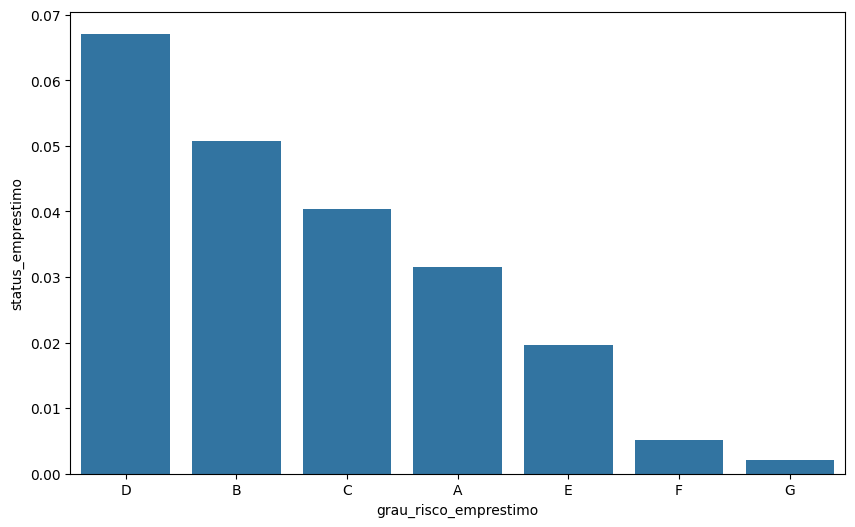

In [34]:
plt.figure(figsize=(10, 6))
aux = df4.loc[df4['status_emprestimo'] == 1]
aux = aux[['grau_risco_emprestimo', 'status_emprestimo']].groupby('grau_risco_emprestimo').count().reset_index()
aux['status_emprestimo'] = aux['status_emprestimo'] / len(df4['status_emprestimo'])
sns.barplot(x='grau_risco_emprestimo', y='status_emprestimo', data=aux.sort_values('status_emprestimo', ascending=False))

##### Empréstimos de valores mais altos podem apresentar uma maior probabilidade de inadimplência, pois representam um compromisso financeiro maior para o mutuário.

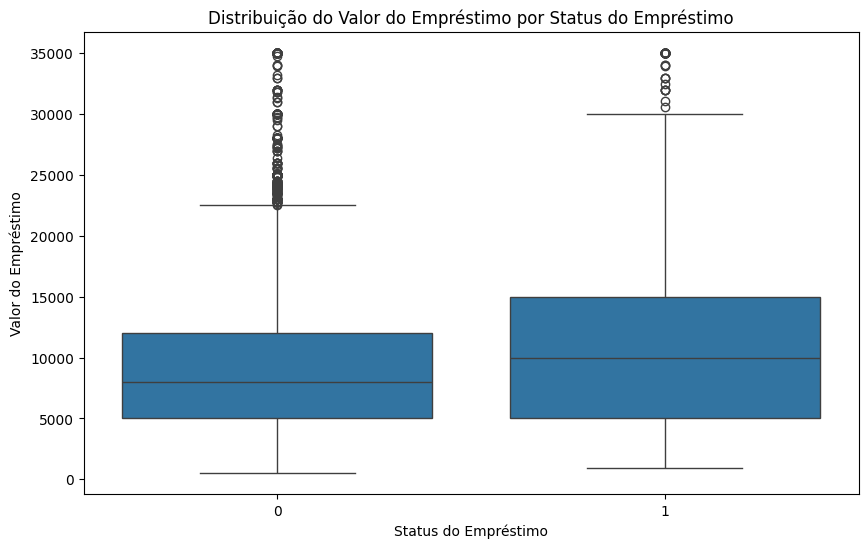

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4, x='status_emprestimo', y='valor_emprestimo')
plt.title('Distribuição do Valor do Empréstimo por Status do Empréstimo')
plt.xlabel('Status do Empréstimo')
plt.ylabel('Valor do Empréstimo')
plt.show()

##### Taxas de juros mais altas podem aumentar a probabilidade de inadimplência, especialmente para mutuários com renda mais baixa ou histórico de crédito comprometido.

<Axes: xlabel='status_emprestimo', ylabel='taxa_juros_emprestimo'>

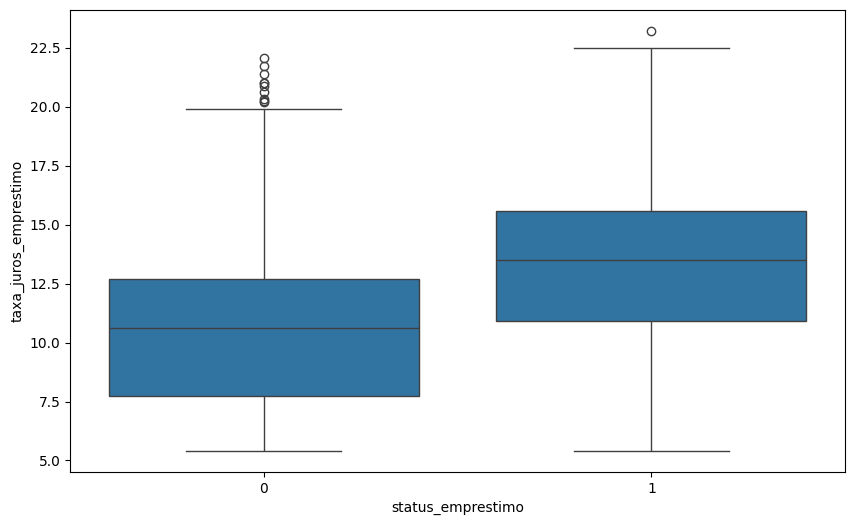

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4, x='status_emprestimo', y='taxa_juros_emprestimo')


##### Uma relação alta entre o valor do empréstimo e a renda da pessoa pode indicar uma capacidade limitada de pagamento e, portanto, uma maior probabilidade de inadimplência.


<Axes: xlabel='status_emprestimo', ylabel='relacao_emprestimo_renda'>

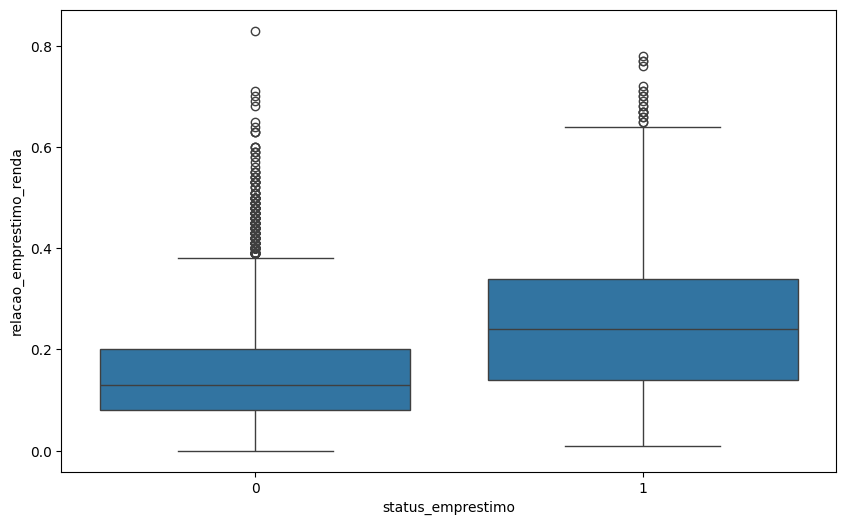

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4, x='status_emprestimo', y='relacao_emprestimo_renda')

##### Uma taxa ajustada de juros pela renda mais alta está associada a uma maior propabilidade de inadimplência

Text(0, 0.5, 'Contagem')

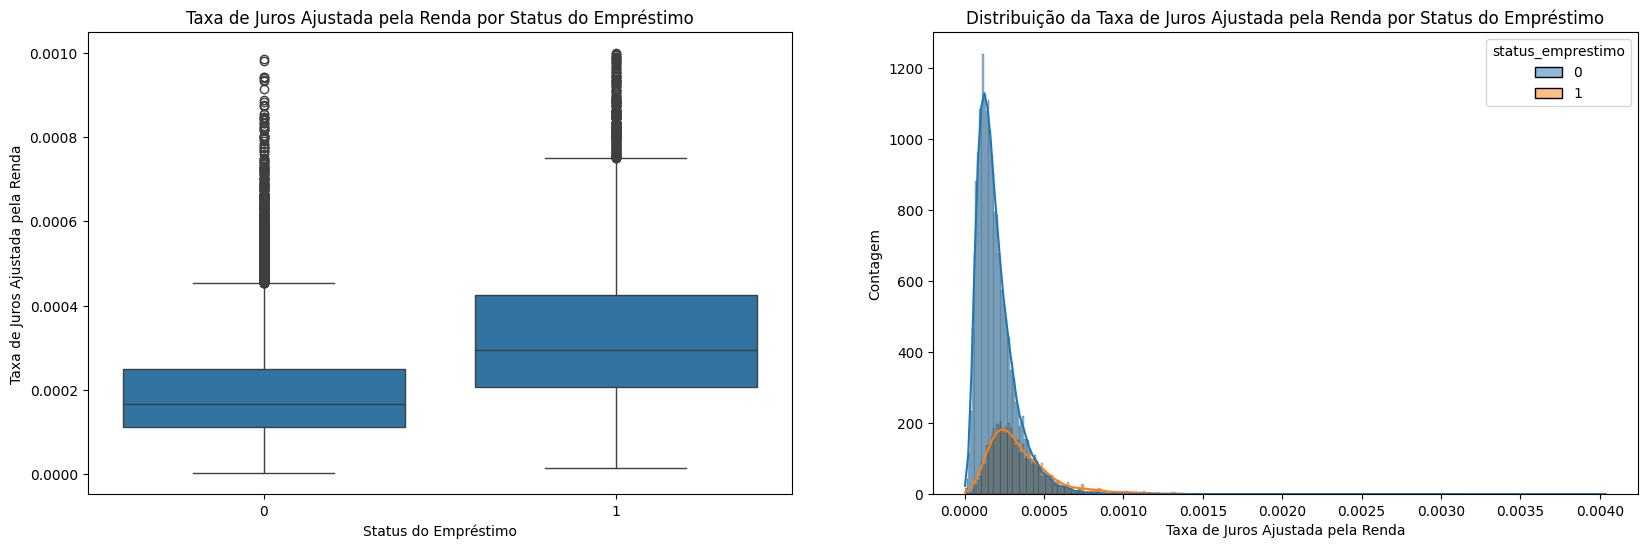

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 6))
plt.subplot( 1, 2, 1 )
sns.boxplot(x='status_emprestimo', y='taxa_juros_ajustada_renda', data=df4.loc[df4['taxa_juros_ajustada_renda'] < 0.0010])
plt.title('Taxa de Juros Ajustada pela Renda por Status do Empréstimo')
plt.xlabel('Status do Empréstimo')
plt.ylabel('Taxa de Juros Ajustada pela Renda')



plt.subplot( 1, 2, 2 )
sns.histplot(data=df4, x='taxa_juros_ajustada_renda', hue='status_emprestimo', kde=True)
plt.title('Distribuição da Taxa de Juros Ajustada pela Renda por Status do Empréstimo')
plt.xlabel('Taxa de Juros Ajustada pela Renda')
plt.ylabel('Contagem')



##### Uma alta proporção do valor do empréstimo em relação a idade está associada a uma maior probabilidade de inadimplência

Text(0, 0.5, 'Contagem')

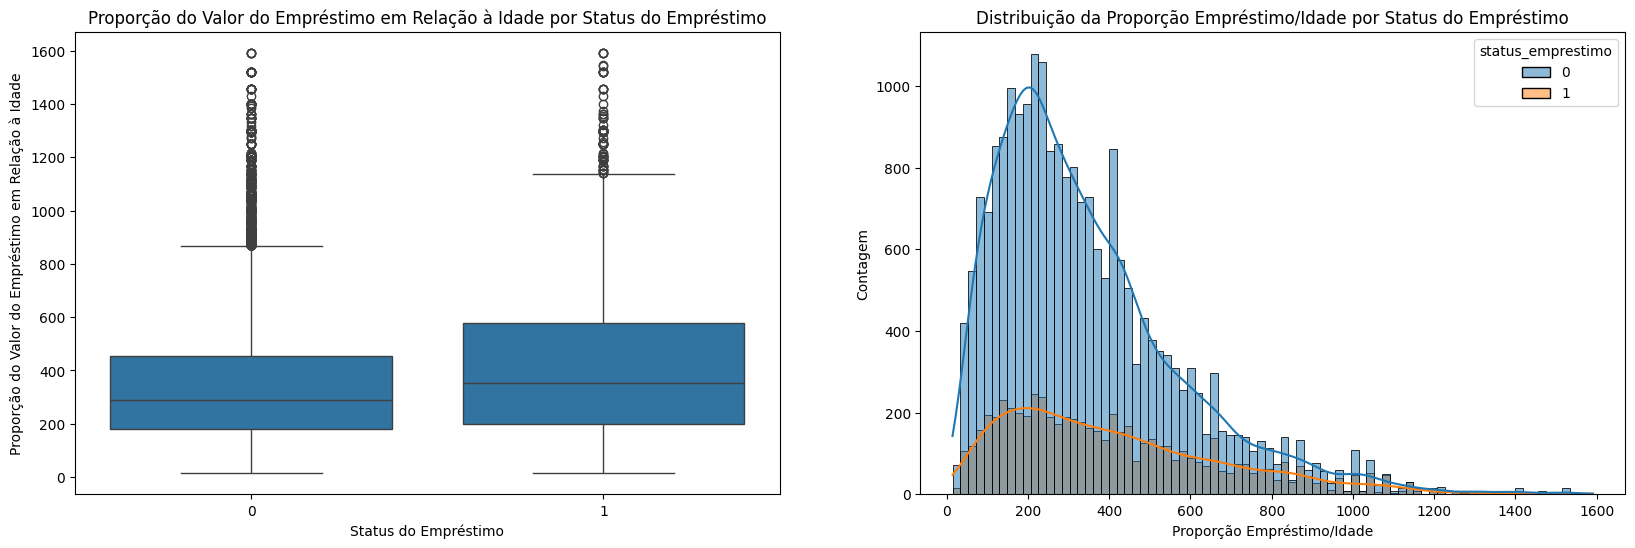

In [39]:
plt.figure(figsize=(20, 6))
plt.subplot( 1, 2, 1 )
sns.boxplot(x='status_emprestimo', y='proporcao_emprestimo_idade', data=df4)
plt.title('Proporção do Valor do Empréstimo em Relação à Idade por Status do Empréstimo')
plt.xlabel('Status do Empréstimo')
plt.ylabel('Proporção do Valor do Empréstimo em Relação à Idade')


plt.subplot( 1, 2, 2 )
sns.histplot(data=df4, x='proporcao_emprestimo_idade', hue='status_emprestimo', kde=True)
plt.title('Distribuição da Proporção Empréstimo/Idade por Status do Empréstimo')
plt.xlabel('Proporção Empréstimo/Idade')
plt.ylabel('Contagem')

##### Uma alta proporção do valor do empréstimo em relação ao tempo de emprego está associada a uma alta probabilidade de inadimplência

<Axes: xlabel='proporcao_emprestimo_tempo_emprego', ylabel='Count'>

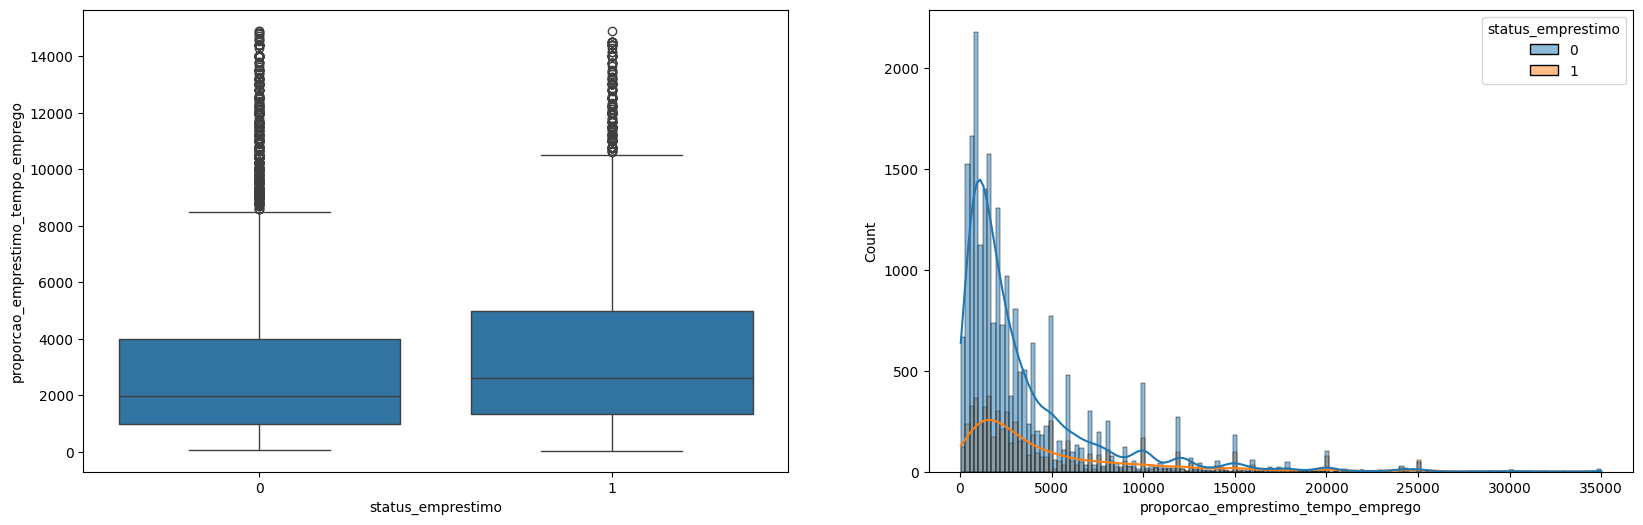

In [40]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='proporcao_emprestimo_tempo_emprego', data=df4.loc[df4['proporcao_emprestimo_tempo_emprego'] < 15000])

plt.subplot(1,2,2)
sns.histplot(data=df4, x='proporcao_emprestimo_tempo_emprego', hue='status_emprestimo', kde=True)

##### Uma alta proporção do valor do empréstimo em relação ao Histórico de Crédito está associada a uma alta probabilidade de inadimplência

<Axes: xlabel='proporcao_emprestimo_historico_credito', ylabel='Count'>

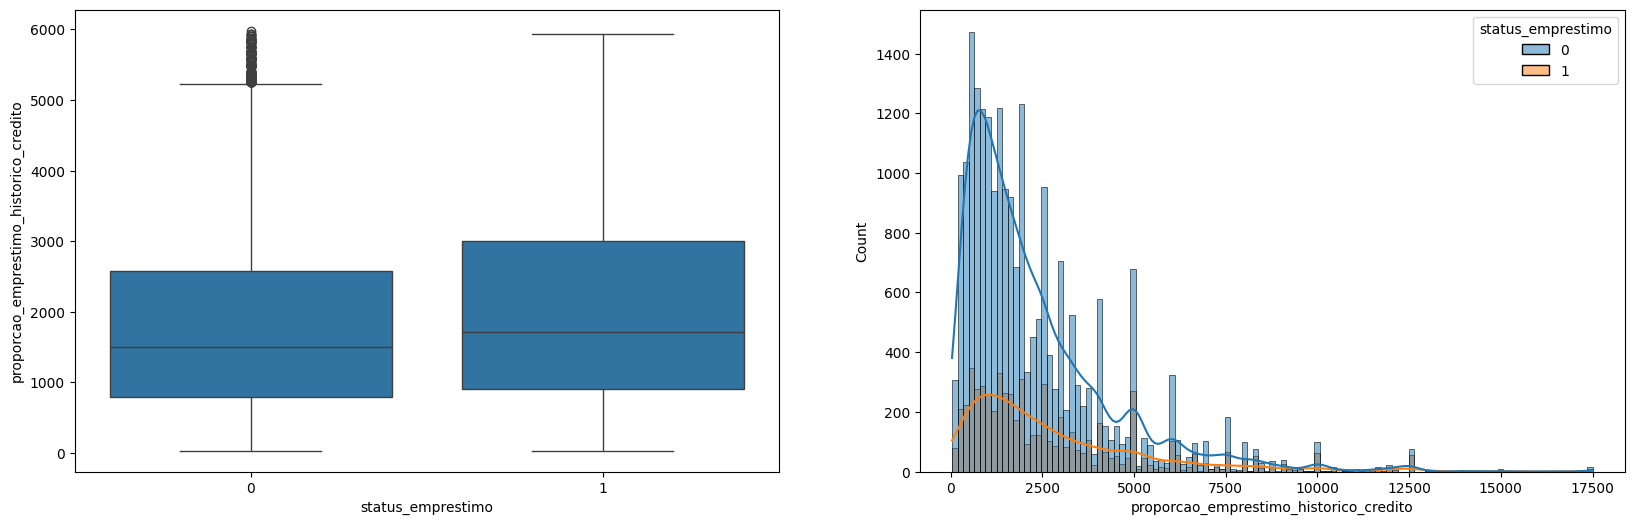

In [41]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='proporcao_emprestimo_historico_credito', data=df4.loc[df4['proporcao_emprestimo_historico_credito'] < 6000])

plt.subplot(1,2,2)
sns.histplot(data=df4, x='proporcao_emprestimo_historico_credito', hue='status_emprestimo', kde=True)

##### Uma baixa proporção da renda em relação ao valor do empréstimo está associada a uma probabilidade maior de inadimplência

<Axes: xlabel='proporcao_renda_emprestimo', ylabel='Count'>

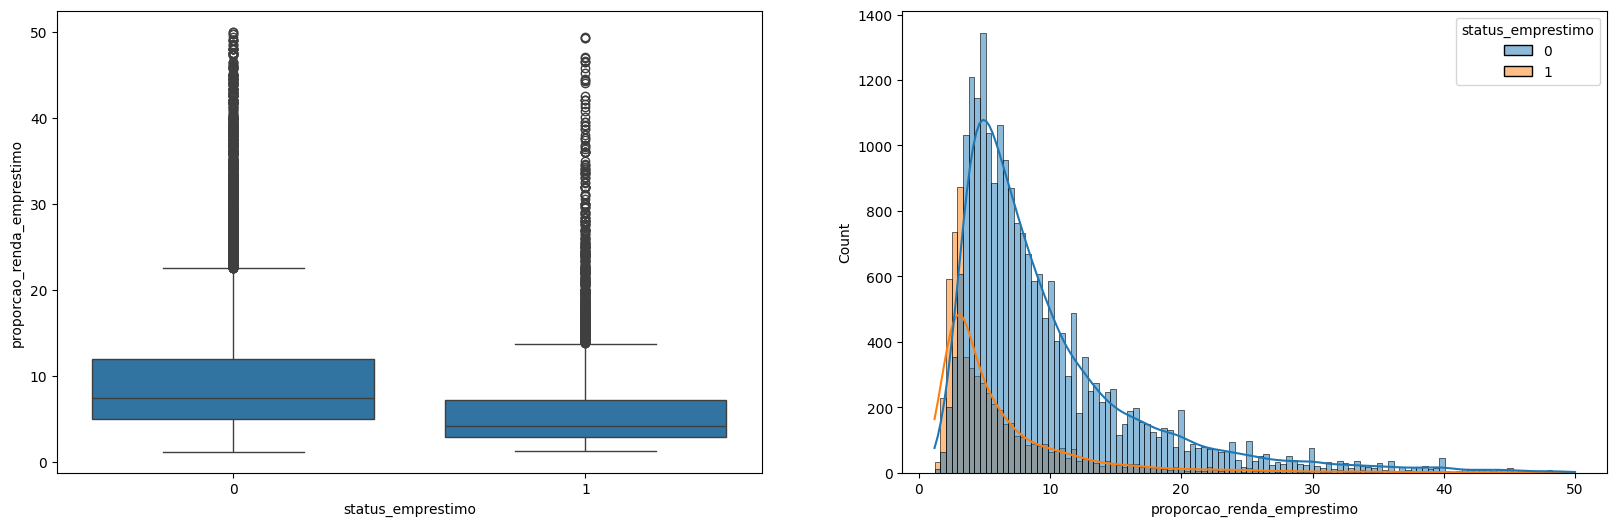

In [42]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.boxplot(x='status_emprestimo', y='proporcao_renda_emprestimo', data=df4.loc[df4['proporcao_renda_emprestimo'] < 50])

plt.subplot(1,2,2)
sns.histplot(data=df4.loc[df4['proporcao_renda_emprestimo'] < 50], x='proporcao_renda_emprestimo', hue='status_emprestimo', kde=True)



##### Pessoas com renda mais alta têm uma menor probabilidade de inadimplência

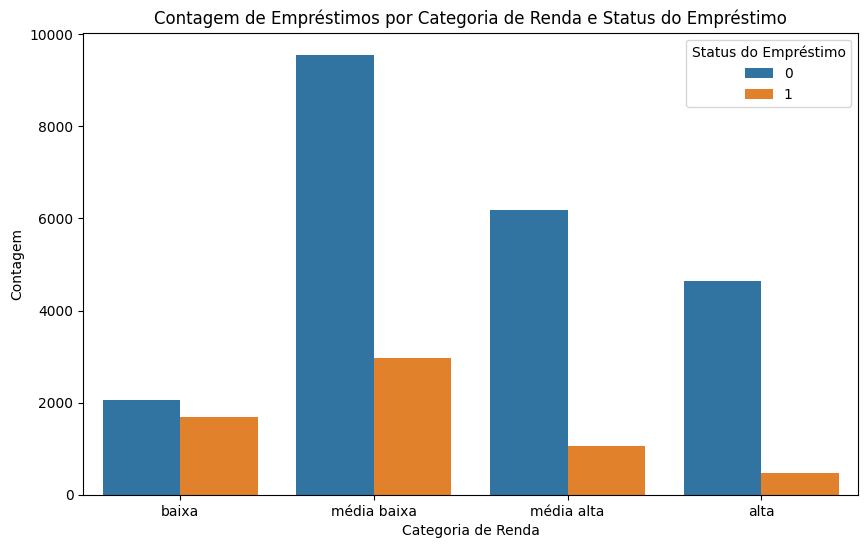

In [43]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df4, x='categoria_renda', hue='status_emprestimo')
plt.title('Contagem de Empréstimos por Categoria de Renda e Status do Empréstimo')
plt.xlabel('Categoria de Renda')
plt.ylabel('Contagem')
plt.legend(title='Status do Empréstimo')
plt.show()

##### Faixas etárias mais jovens podem estar associadas a uma maior probabilidade de inadimplência

C:\Users\thale\AppData\Local\Temp\ipykernel_27484\4272906175.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df4.groupby(['categoria_idade', 'status_emprestimo']).size().unstack().plot(kind='pie', subplots=True, figsize=(15, 8), autopct='%1.1f%%')


<Figure size 1000x600 with 0 Axes>

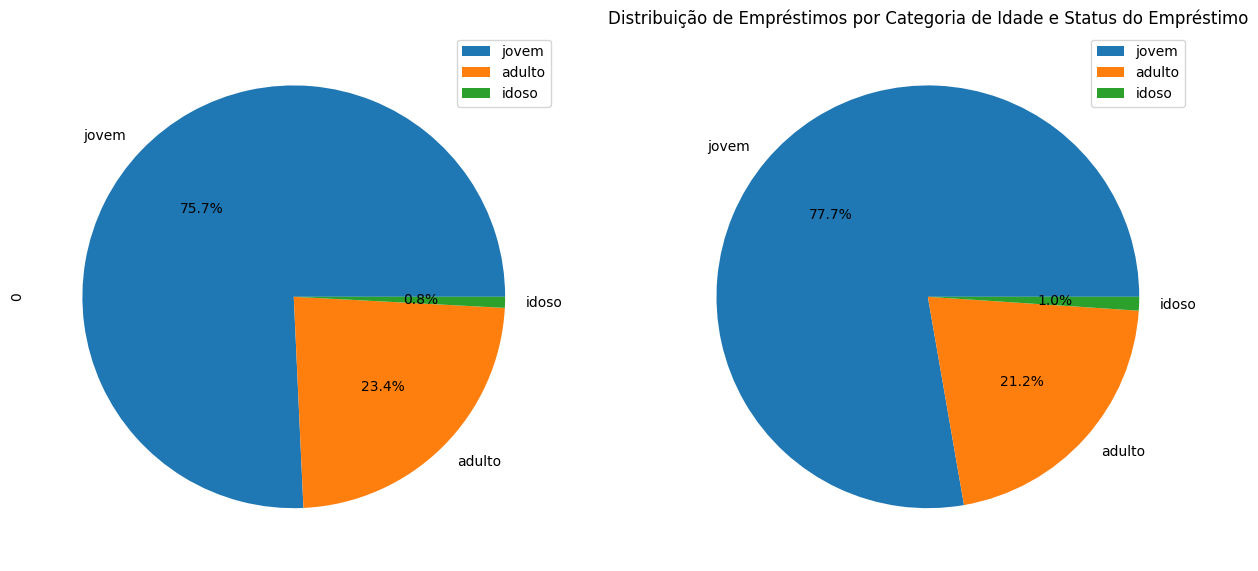

In [44]:
plt.figure(figsize=(10, 6))
df4.groupby(['categoria_idade', 'status_emprestimo']).size().unstack().plot(kind='pie', subplots=True, figsize=(15, 8), autopct='%1.1f%%')
plt.title('Distribuição de Empréstimos por Categoria de Idade e Status do Empréstimo')
plt.ylabel('')
plt.show()

## 4.3 Análise Multivariada

### 4.3.1 Atributos Numéricos

In [45]:
num_attributes3 = df4.select_dtypes(exclude=['object','category'])

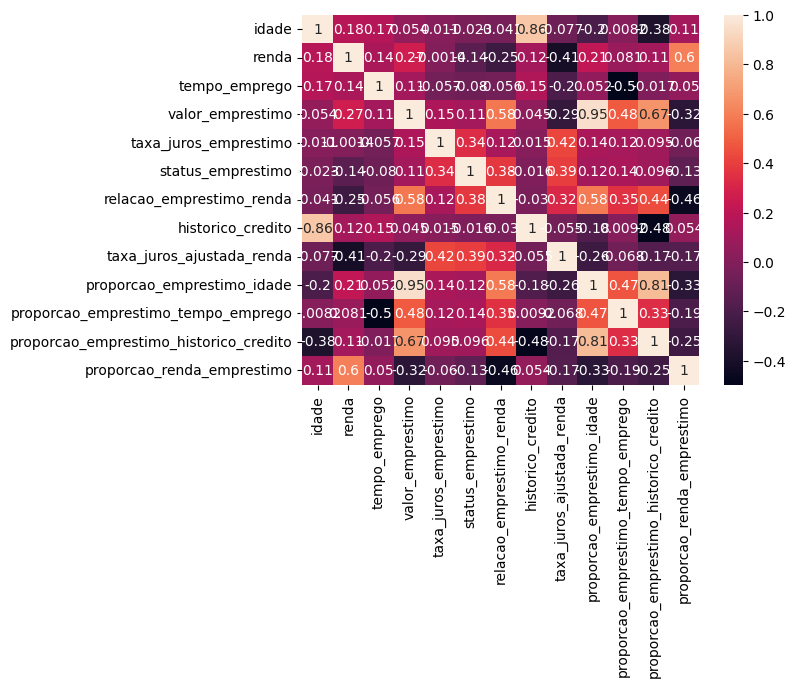

In [46]:
correlation = num_attributes3.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Atributos Categóricos

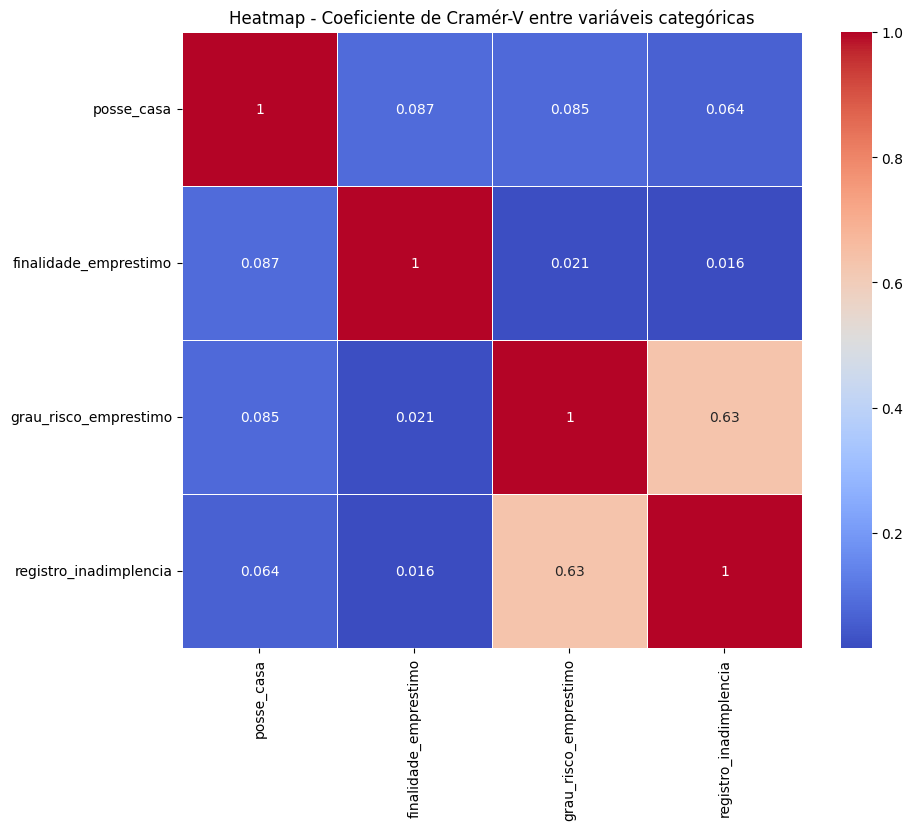

In [47]:
a = df4.select_dtypes( include=['object', 'category'] )

# Selecionar apenas colunas categóricas
categorical_columns = df4.select_dtypes(include='object').columns

# Criar uma matriz para armazenar os valores de Cramér-V
cramer_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calcular o coeficiente de Cramér-V para todas as combinações de colunas categóricas
for col1 in categorical_columns:
    for col2 in categorical_columns:
        cramer_v_matrix.loc[col1, col2] = cramer_v(df4[col1], df4[col2])

# Plotar um heatmap dos valores de Cramér-V
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_v_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap - Coeficiente de Cramér-V entre variáveis categóricas')
plt.show()

# 5.0 Data Preparation

In [48]:
df5 = df4.copy()

In [49]:
df5.isna().sum()

idade                                     0
renda                                     0
posse_casa                                0
tempo_emprego                             0
finalidade_emprestimo                     0
grau_risco_emprestimo                     0
valor_emprestimo                          0
taxa_juros_emprestimo                     0
status_emprestimo                         0
relacao_emprestimo_renda                  0
registro_inadimplencia                    0
historico_credito                         0
taxa_juros_ajustada_renda                 0
proporcao_emprestimo_idade                0
proporcao_emprestimo_tempo_emprego        0
proporcao_emprestimo_historico_credito    0
proporcao_renda_emprestimo                0
categoria_renda                           0
categoria_idade                           0
dtype: int64

In [50]:
df5['proporcao_emprestimo_tempo_emprego'].min()

47.61904761904762

In [51]:
df5.loc[df5.index == 16]

,idade,renda,posse_casa,tempo_emprego,finalidade_emprestimo,grau_risco_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,registro_inadimplencia,historico_credito,taxa_juros_ajustada_renda,proporcao_emprestimo_idade,proporcao_emprestimo_tempo_emprego,proporcao_emprestimo_historico_credito,proporcao_renda_emprestimo,categoria_renda,categoria_idade
16,23,120000,RENT,1.0,EDUCATION,A,35000,7.9,0,0.29,N,4,0.000066,1521.73913,35000.0,8750.0,3.428571,alta,jovem


In [52]:
# min_val = df5[column_name].min()
# max_val = data[column_name].max()
# data[column_name] = (data[column_name] - min_val) / (max_val - min_val)

# #return data

In [53]:
# df5.loc[df5['proporcao_emprestimo_tempo_emprego'].isna()]

## 5.1 Variáveis Numéricas

In [54]:
num_columns = num_attributes3.columns

for i in num_columns:
    df5 = rescale_column(df5, i)

In [55]:
df5.isna().sum()

idade                                     0
renda                                     0
posse_casa                                0
tempo_emprego                             0
finalidade_emprestimo                     0
grau_risco_emprestimo                     0
valor_emprestimo                          0
taxa_juros_emprestimo                     0
status_emprestimo                         0
relacao_emprestimo_renda                  0
registro_inadimplencia                    0
historico_credito                         0
taxa_juros_ajustada_renda                 0
proporcao_emprestimo_idade                0
proporcao_emprestimo_tempo_emprego        0
proporcao_emprestimo_historico_credito    0
proporcao_renda_emprestimo                0
categoria_renda                           0
categoria_idade                           0
dtype: int64

## 5.2 Variáveis Categóricas

In [56]:
cat_att = df5.select_dtypes(include=['object', 'category'])

In [57]:
le = LabelEncoder()
for i in cat_att.columns:
    df5[i] = le.fit_transform(df5[i].values)

# 6.0 Seleção de atributos

In [58]:
df6 = df5.copy()

In [59]:
df6.head()

,idade,renda,posse_casa,tempo_emprego,finalidade_emprestimo,grau_risco_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,relacao_emprestimo_renda,registro_inadimplencia,historico_credito,taxa_juros_ajustada_renda,proporcao_emprestimo_idade,proporcao_emprestimo_tempo_emprego,proporcao_emprestimo_historico_credito,proporcao_renda_emprestimo,categoria_renda,categoria_idade
0,0.016129,0.009173,3,1.000000,4,3,1.000000,0.595506,1.0,0.710843,1,0.035714,0.066790,1.000000,0.006779,0.666009,0.000401,3,2
1,0.008065,0.000934,2,0.032787,1,1,0.014493,0.321348,0.0,0.120482,0,0.000000,0.287162,0.021142,0.004360,0.026654,0.007003,1,2
2,0.040323,0.000934,0,0.000000,3,2,0.144928,0.418539,1.0,0.686747,0,0.035714,0.331839,0.130478,0.155995,0.102994,0.000451,1,2
3,0.024194,0.010257,3,0.024590,3,2,1.000000,0.551124,1.0,0.638554,0,0.000000,0.057120,0.956128,0.248978,1.000000,0.000556,2,2
4,0.032258,0.008406,3,0.057377,3,2,1.000000,0.497191,1.0,0.662651,1,0.071429,0.064507,0.915912,0.123808,0.499013,0.000292,3,2


## 6.1 Feature Importance - Árvore

In [60]:
X = df6.drop(columns=['status_emprestimo'])
y = df6['status_emprestimo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=42)

In [61]:
# model = RandomForestClassifier()

# # Treinar o modelo
# model.fit(X_train, y_train)

# # Obter a importância das features
# importances = model.feature_importances_

In [62]:
# feature_names = X_train.columns  # Supondo que X seja um DataFrame do Pandas

# # Ordenar as importâncias e os nomes das features juntos
# sorted_indices = np.argsort(importances)[::-1]
# sorted_importances = importances[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# # Criar um gráfico de barras
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='b', align='center')

# # Adicionar nome das features no eixo x
# plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
# plt.xlabel('Feature')
# plt.ylabel('Importance')

# # Adicionar título ao gráfico
# plt.title('Feature Importance')

# # Mostrar o gráfico
# plt.tight_layout()
# plt.show()

In [63]:
# # Ordenar as importâncias e os nomes das features juntos
# sorted_indices = np.argsort(importances)[::-1]
# sorted_importances = importances[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# # Realizar a análise de cotovelo
# num_features = len(importances)
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, num_features + 1), np.cumsum(sorted_importances), marker='o', linestyle='-')
# plt.xlabel('Número de Features Selecionadas')
# plt.ylabel('Variância Explicada Acumulada')
# plt.title('Análise de Cotovelo')
# plt.grid(True)
# plt.show()


In [64]:
# chosen_features = sorted_feature_names[:15]

## 6.2 Regularização das Regressões

### 6.2.1 Lasso

In [65]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectFromModel

In [66]:
lasso_model = Lasso(alpha=0.005, random_state=42)
lasso_model.fit(X_train, y_train)

# Usar SelectFromModel para selecionar features com base nas importâncias do Lasso
select_model = SelectFromModel(lasso_model)
select_model.fit(X_train, y_train)

# Obter as features selecionadas
selected_features = X_train.columns[select_model.get_support()]

# Imprimir as features selecionadas
print(selected_features)

Index(['posse_casa', 'finalidade_emprestimo', 'grau_risco_emprestimo',
       'relacao_emprestimo_renda'],
      dtype='object')


In [67]:
chosen_features = selected_features

### 6.2.2 Ridge

## 6.3 BORUTA

# 7.0 Machine Learning Model

In [68]:
df7 = df6.copy()

In [69]:
X = df7[chosen_features] #df7.drop('status_emprestimo', axis=1)
y = df7['status_emprestimo']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)



# # Definição do Fold
# num_folds = 30
# scores = ['precision', 'recall']
# kfold = KFold(num_folds, shuffle=True, random_state=42)

In [71]:
def cross_validation_kfold(model, X, y):
    num_folds = 30
    scores = ['precision', 'recall']
    kfold = KFold(num_folds, shuffle=True, random_state=42)

    scores_result = cross_validate(model, X, y, scoring=scores, cv=kfold)
    model_name = model.__class__.__name__
    precision_mean = scores_result['test_precision'].mean()
    recall_mean = scores_result['test_recall'].mean()

    result_dict = {'model': model_name, 'precision': precision_mean, 'recall': recall_mean}
    result_df = pd.DataFrame([result_dict])

    return result_df

## 7.1 Random Forest

In [72]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
yhat = rf.predict(X_test)

### 7.1.1 Random Forest Performance

In [73]:
print( precision_score(y_test, yhat) )
print( recall_score(y_test, yhat) )

0.847926267281106
0.5929108485499462


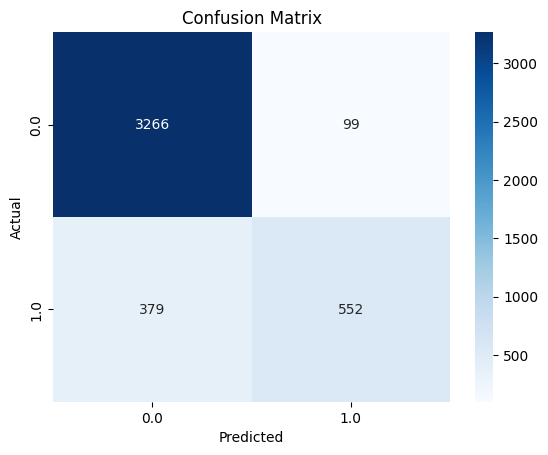

In [74]:
plot_confusion_matrix(y_test, yhat, labels=y_test.unique())

### 7.1.2 Random Forest Performance - Cross Validation

In [75]:
rf = RandomForestClassifier()
rf_cross_result = cross_validation_kfold(rf, X, y)

In [76]:
rf_cross_result

,model,precision,recall
0,RandomForestClassifier,0.858638,0.616486


## 7.2 Decision Tree

In [77]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

yhat_dt = dt.predict(X_test)


### 7.2.1 Decision Tree Performance

In [78]:
print( precision_score(y_test, yhat_dt) )
print( recall_score(y_test, yhat_dt) )

0.864951768488746
0.5778732545649838


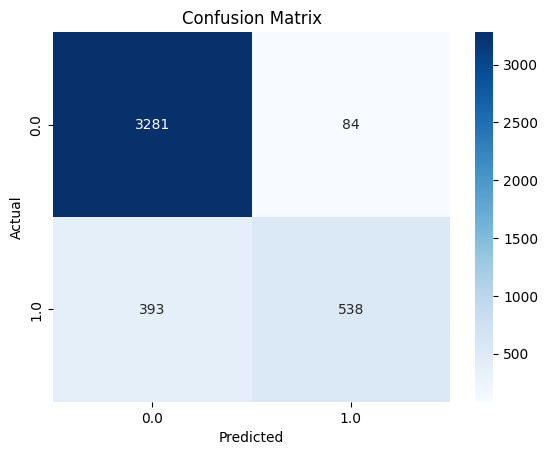

In [79]:
plot_confusion_matrix(y_test, yhat_dt, labels=y_test.unique())

### 7.2.2 Decision Tree Performance - Cross Validation

In [80]:
dt = DecisionTreeClassifier()
dt_cross_result = cross_validation_kfold(dt, X, y)

In [81]:
dt_cross_result

,model,precision,recall
0,DecisionTreeClassifier,0.863848,0.604711


## 7.3 LightGBM Classifier

In [82]:
lg = lgb.LGBMClassifier()

lg.fit(X_train, y_train)
yhat_lg = lg.predict(X_test)


[LightGBM] [Info] Number of positive: 5272, number of negative: 19070
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 24342, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216580 -> initscore=-1.285707
[LightGBM] [Info] Start training from score -1.285707


### 7.3.1 LightGBM Performance

In [83]:
print( precision_score(y_test, yhat_lg) )
print( recall_score(y_test, yhat_lg) )

0.8892405063291139
0.6036519871106337


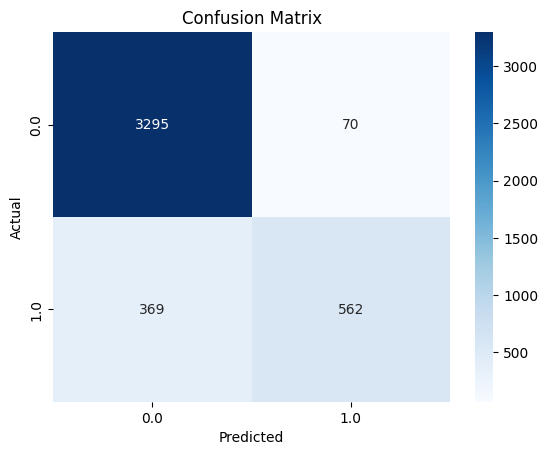

In [84]:
plot_confusion_matrix(y_test, yhat_lg, labels=y_test.unique())

### 7.3.2 LightGBM Performance - Cross Validation

In [85]:
lg = lgb.LGBMClassifier()
lg_cross_result = cross_validation_kfold(lg, X, y)

[LightGBM] [Info] Number of positive: 6003, number of negative: 21680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 27683, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216848 -> initscore=-1.284131
[LightGBM] [Info] Start training from score -1.284131
[LightGBM] [Info] Number of positive: 6001, number of negative: 21682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 27683, number of used features: 4
[LightGBM] [Info] [binary:

In [86]:
lg_cross_result

,model,precision,recall
0,LGBMClassifier,0.880086,0.629109


## 7.4 XGBoost

In [87]:
# Criar o classificador XGBoost
xgb_classifier = xgb.XGBClassifier()

# Treinar o classificador
xgb_classifier.fit(X_train, y_train)

# Fazer previsões
yhat_xgb = xgb_classifier.predict(X_test)

### 7.4.1 XGBoost Performance

In [88]:
print( precision_score(y_test, yhat_xgb) )
print( recall_score(y_test, yhat_xgb) )

0.8980582524271845
0.5961331901181526


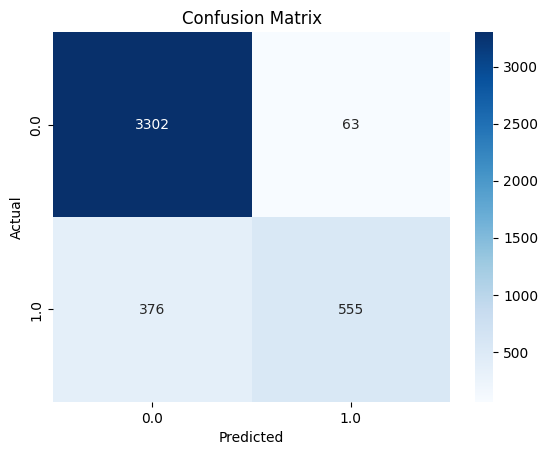

In [89]:
plot_confusion_matrix(y_test, yhat_xgb, labels=y_test.unique())

### 7.4.2 XGBoost Performance - Cross Validation

In [90]:
xgb_classifier = xgb.XGBClassifier()
xgb_cross_result = cross_validation_kfold(xgb_classifier, X, y)

In [91]:
xgb_cross_result

,model,precision,recall
0,XGBClassifier,0.876331,0.623844


# All Results

In [92]:
df_all = pd.concat([rf_cross_result, dt_cross_result, lg_cross_result, xgb_cross_result])

In [93]:
df_all.sort_values('precision', ascending=False)

,model,precision,recall
0,LGBMClassifier,0.880086,0.629109
0,XGBClassifier,0.876331,0.623844
0,DecisionTreeClassifier,0.863848,0.604711
0,RandomForestClassifier,0.858638,0.616486
